# EDA regarding:
* Tries of balancing future batches on tumor area%
* Justification for smallest feature space in U-Net 

# Install

In [1]:
# !pip install monai-weekly

# Import libraries

In [38]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

import monai
from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,
    Compose,
    LoadImageD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt
import random


#### Set seeds

In [3]:
import sys
from tqdm import tqdm

In [4]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Hyperparameters

In [5]:
BATCH_SIZE = 1

COLOUR_CHANNELS = 1
NO_STACKED_IMGS = 6 # number of images to stack for the model (Determined by the average size of the tumour in EDA part 1)

In [6]:
crt_dir = os.getcwd()

datasets_path = f'{crt_dir}/datasets/MedicalDecathlon/'

# Visualize data

## TRAIN

In [7]:
# Set up transform
KEYS = ["image", "label"]

base_transform = Compose([
    LoadImageD(keys=KEYS),
])

In [8]:
import pickle as pkl


with open(f'{crt_dir}/tumorous_stacks_training.pkl', 'rb') as f:
    patients = pkl.load(f)


In [9]:
patients

{0: [334,
  335,
  336,
  337,
  338,
  339,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354,
  355,
  356,
  357,
  358,
  359,
  360,
  361,
  362,
  363,
  364,
  365,
  366,
  367,
  368,
  369,
  370,
  371,
  372,
  373,
  374,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  399,
  400,
  401,
  402,
  403],
 1: [179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219],
 2: [155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  

In [ ]:
from read_msd_functions import read_msd

In [10]:
def read_memoized_data(path, split_name):
    crt_path = f'{path}/{split_name}'
    
    no_patients = len(os.listdir(f'{crt_path}/images'))
    
    patients = []

    for patient_id in range(no_patients):
        img = torch.load(f'{crt_path}/images/patient_{patient_id}.pt')
        label = torch.load(f'{crt_path}/labels/patient_{patient_id}.pt')
        patients.append({"image": img.squeeze(0), "label": label.squeeze(0)})
    
    return patients

    

In [11]:
# Load dataset
memoized_path = f'/raid/CataChiru/MedicalDecathlonTensors/'
# memoized_path = f'./datasets/MedicalDecathlonJustLungs'
# memoized_path = f'./datasets/MedicalDecathlonJustTumors'

memoized_flag = True

if not os.path.exists(memoized_path) or not memoized_flag:
    train_name = 'training' # From Monai: ['training', 'validation', 'test']
    train_dataset = DecathlonDataset(root_dir = f'{datasets_path}{train_name}/',
                            task = "Task06_Lung", section = train_name,
                            transform = base_transform, download = False)

    for i in range(len(train_dataset)):
        train_dataset[i]['image'] = train_dataset[i]['image'][:, :, patients[i]]
        train_dataset[i]['label'] = train_dataset[i]['label'][:, :, patients[i]]
else:
    print('Loading memoized data')
    train_dataset = read_memoized_data(memoized_path, 'training')
    

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False) #, num_workers = 1)

Loading memoized data


In [12]:
for patient_batch in tqdm(train_loader):
    print(patient_batch['image'].shape)
    break


  0%|          | 0/51 [00:00<?, ?it/s]

torch.Size([1, 512, 512, 589])


In [13]:
def average_tumour_surface(crt_loader, print_flag = False):
    '''
    Computes the average number of pixels that the tumour covers in the images of each patient
    '''
    surface_percentage_per_patient = []

    i = 0
    for patient_batch in tqdm(crt_loader):
        label = patient_batch['label']
        percentage_area = np.mean(np.sum(label.cpu().numpy(), axis = (1, 2)))

        surface_percentage_per_patient.append(percentage_area)

        if print_flag:
            print(f"For patient {i} the tumour covers {percentage_area} pixels")
        i += 1

    return surface_percentage_per_patient



In [14]:
avg_tumour_area = average_tumour_surface(train_loader, print_flag = False)

100%|██████████| 51/51 [00:05<00:00, 10.13it/s]


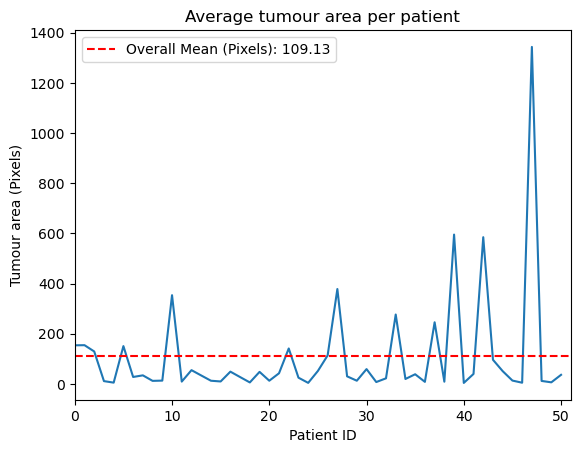

In [15]:
plt.plot(avg_tumour_area)
plt.title('Average tumour area per patient')

# Put the mean value on the plot
mean_tumour_area = np.mean(avg_tumour_area)
plt.axhline(y = mean_tumour_area, color = 'r', linestyle = '--', label = f'Overall Mean (Pixels): {mean_tumour_area:.2f}')



plt.ylabel('Tumour area (Pixels)')
plt.xlabel('Patient ID')
plt.xlim(0, len(avg_tumour_area))
plt.legend()
plt.show()


In [16]:
def tumour_percentages_per_training_batches(crt_loader, NO_STACKED_IMGS):
    '''
    Computes for a specified number of stacked images the percentage of tumour voxels in each batch

    Returns a list of tuples (voxels_with_tumour, percentage_of_tumour_in_batch_volume)
    '''
    percentages_batches = []

    patient_idx = 0
    lens = []
    for patient_batch in crt_loader:
        print(f'Patient {patient_idx}, total slices: {patient_batch["label"].shape[-1]}')
        patient_label = patient_batch['label'][0].numpy()
        patient_idx += 1

        crt_len = 0

        for i in range(0, patient_label.shape[-1] - NO_STACKED_IMGS + 1):
            crt_len += 1
            crt_label = patient_label[..., i:i+NO_STACKED_IMGS]
            assert crt_label.shape[-1] == NO_STACKED_IMGS, "Current iterator goes too far and destroys the shape of the label"

            voxels_with_tumour = np.sum(crt_label)
            volume = np.prod(crt_label.shape)

            percentages_batches.append((voxels_with_tumour, 100*voxels_with_tumour / volume))

        lens.append(crt_len)

    print(lens)

    return percentages_batches

In [17]:
percentages_batches_tr = tumour_percentages_per_training_batches(train_loader, NO_STACKED_IMGS)

Patient 0, total slices: 589
Patient 1, total slices: 267
Patient 2, total slices: 227
Patient 3, total slices: 450
Patient 4, total slices: 277
Patient 5, total slices: 260
Patient 6, total slices: 125
Patient 7, total slices: 273
Patient 8, total slices: 251
Patient 9, total slices: 636
Patient 10, total slices: 301
Patient 11, total slices: 304
Patient 12, total slices: 115
Patient 13, total slices: 241
Patient 14, total slices: 249
Patient 15, total slices: 289
Patient 16, total slices: 282
Patient 17, total slices: 291
Patient 18, total slices: 276
Patient 19, total slices: 296
Patient 20, total slices: 567
Patient 21, total slices: 423
Patient 22, total slices: 242
Patient 23, total slices: 243
Patient 24, total slices: 251
Patient 25, total slices: 155
Patient 26, total slices: 241
Patient 27, total slices: 304
Patient 28, total slices: 228
Patient 29, total slices: 322
Patient 30, total slices: 226
Patient 31, total slices: 256
Patient 32, total slices: 531
Patient 33, total sl

In [18]:
percentages_batches_tr

[(0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),

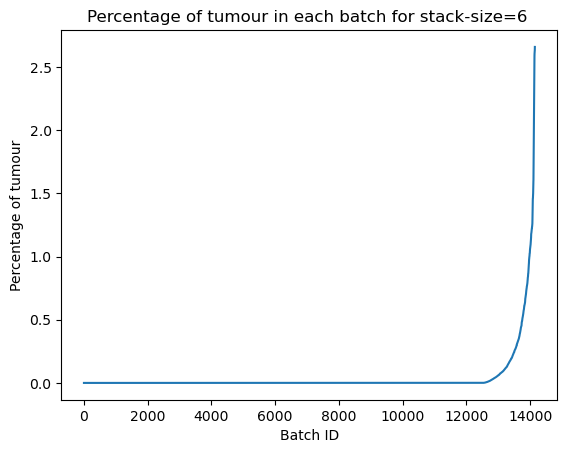

In [19]:
percentages_only_tr = np.array([perc[1] for perc in percentages_batches_tr])
percentages_only_tr = sorted(percentages_only_tr)
plt.plot(percentages_only_tr)
plt.title(f'Percentage of tumour in each batch for stack-size={NO_STACKED_IMGS} ')
plt.xlabel('Batch ID')
plt.ylabel('Percentage of tumour')
plt.show()

In [20]:
len(percentages_only_tr)

14148

In [21]:
# Tried to find a way of binning the percentages so that the distribution is somewhat even
# Using logarithmic bins oversaturates 2 bins and leaves the rest empty
# Using linear bins does not work either
# Neither does using 1/x bins
# It looks like it is 1/x up to one point and then a polynomial function

bins = [0, 0.00000001] + [1/x for x in [1,2,3,4,5,6,7,8]] + [2]

bins = sorted(bins)
print(bins)
frequencies = {bin: 0 for bin in bins}


for perc in percentages_only_tr:
    for i in range(len(bins) + 1):
        # print(perc, bins[i])
        if i + 1 == len(bins):
            frequencies[bins[i]] += 1
            break
        elif perc < bins[i + 1]:
            frequencies[bins[i]] += 1
            break

frequencies

[0, 1e-08, 0.125, 0.14285714285714285, 0.16666666666666666, 0.2, 0.25, 0.3333333333333333, 0.5, 1.0, 2]


{0: 12517,
 1e-08: 744,
 0.125: 35,
 0.14285714285714285: 51,
 0.16666666666666666: 81,
 0.2: 79,
 0.25: 114,
 0.3333333333333333: 132,
 0.5: 223,
 1.0: 138,
 2: 34}

In [22]:
sum(frequencies.values())

14148

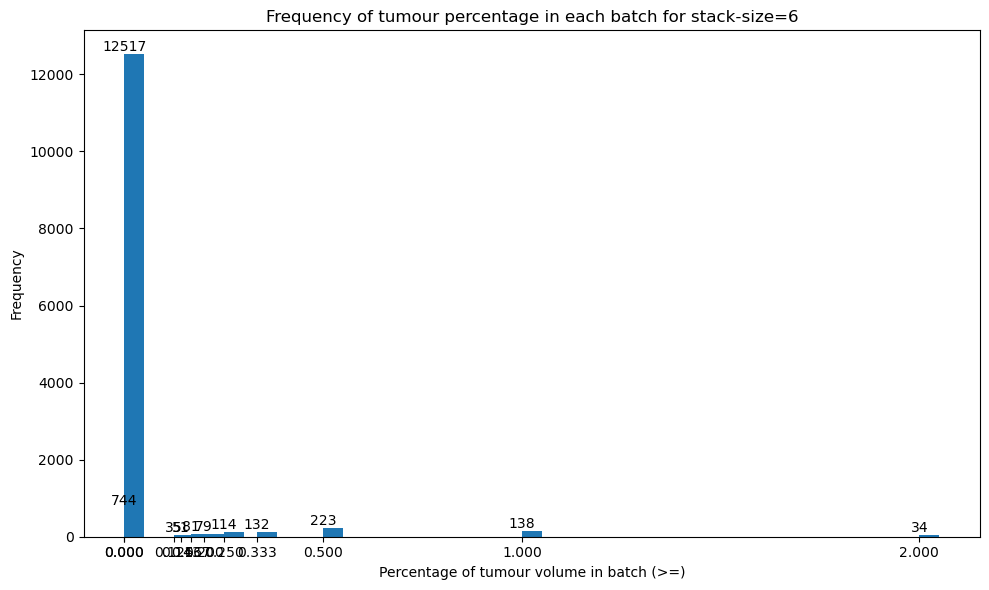

In [23]:
# frequencies = np.linspace(0, 3, 10)

# Logarithmic scale histogram

plt.figure(figsize=(10, 6))
plt.bar(bins, frequencies.values(), align='edge', width=0.05)

# Put count on top of the bars
for i in range(len(bins)):
    plt.text(bins[i], frequencies[bins[i]], str(frequencies[bins[i]]), ha='center', va='bottom')
plt.xticks(bins)

plt.title(f'Frequency of tumour percentage in each batch for stack-size={NO_STACKED_IMGS}')
plt.xlabel('Percentage of tumour volume in batch (>=)')
# plt.x
plt.ylabel('Frequency')

#Tight layout
plt.tight_layout()
# plt.gca().set_xscale("log")
plt.show()

In [29]:
zero_stacks = frequencies[0] + frequencies[1]


print(f'Number of batches with 0% tumour: {zero_stacks}')

print(f'Number of batches with > 0% tumour: {len(percentages_only_tr) - zero_stacks}')

print(f'Out of those, {sum(list(frequencies.values())[-3:])} are in the last 3 bins')

Number of batches with 0% tumour: 12655
Number of batches with > 0% tumour: 1493
Out of those, 395 are in the last 3 bins


In [35]:
def hyperparam_tuning_no_stacks(crt_loader, max_stacks, finetune_zero_batches = False, finetune_tumour_percentage = False):
    '''
    Iterates over a range of stack sizes and computes:
    - The number of batches with 0% tumour if finetune_zero_batches is True
        In this set-up, it will stop when the number of batches with 0% tumour starts increasing
        We want to minimize the number of batches with 0% tumour, because it poissons the training

    - The average percentage volume of tumour in each batch if finetune_tumour_percentage is True
        Once preprocessing is done on the dataset, we want a stack size that has a good distribution of tumour percentages
        We keep track of the total number of batches for each stack size, as it is easier to have a higher percentage of tumour in a smaller batch
        We want to maximize the average percentage of tumour in each batch, taking into account the total number of batches
    '''

    NO_STACKED_IMGS_RANGE = range(3, max_stacks+1)

    no_zero_batches, tumour_percentage = [], []

    for crt_no_stacks in NO_STACKED_IMGS_RANGE:
        print(f'Running for stack size: {crt_no_stacks}/{max_stacks}')

        zero_batches = 0
        total_batches = 0
        tumour_percentage_in_batch = []

        for patient_batch in tqdm(crt_loader):
            patient_label = patient_batch['label'][0].numpy()

            for i in range(0, patient_label.shape[-1] - crt_no_stacks + 1):
                crt_label = patient_label[:, :, i:i+crt_no_stacks]
                assert crt_label.shape[-1] == crt_no_stacks, "Current iterator goes too far and destroys the shape of the label"


                if finetune_zero_batches:
                    zero_batches += (np.sum(crt_label) == 0)

                if finetune_tumour_percentage:
                    tumour_percentage_in_batch.append(100*np.sum(crt_label) / np.prod(crt_label.shape))
    
                total_batches += 1

        tumour_percentage_in_batch = np.mean(tumour_percentage_in_batch)
        if finetune_tumour_percentage:
            tumour_percentage.append((crt_no_stacks, tumour_percentage_in_batch, total_batches))

        # if len(no_zero_batches) !=0:
        #     # Daca am pentru un numar de stackuri mai multe batchuri cu 0% tumour decat pentru numarul anterior, atunci ma opresc pentru ca deja baga prea multe 0-uri
        #     if zero_batches > no_zero_batches[-1] + 50:
        #         no_zero_batches.append(zero_batches)
        #     else:
        #         no_zero_batches.append(no_zero_batches[-1])

        if finetune_tumour_percentage:
            no_zero_batches.append((crt_no_stacks, zero_batches, total_batches))


    return no_zero_batches, tumour_percentage

In [143]:
no_zero_batches, tumour_percentage = hyperparam_tuning_no_stacks(train_loader, 6, finetune_zero_batches=False, finetune_tumour_percentage=True)

Running for stack size: 3/6


100%|██████████| 51/51 [01:05<00:00,  1.28s/it]


Running for stack size: 4/6


100%|██████████| 51/51 [01:08<00:00,  1.35s/it]


Running for stack size: 5/6


100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Running for stack size: 6/6


100%|██████████| 51/51 [01:12<00:00,  1.43s/it]


In [144]:
no_zero_batches

[(3, 0, 14301), (4, 0, 14250), (5, 0, 14199), (6, 0, 14148)]

In [145]:
tumour_percentage

[(3, 0.04081835439009947, 14301),
 (4, 0.040964441132127195, 14250),
 (5, 0.041111577303529295, 14199),
 (6, 0.04125977425309673, 14148)]

In [ ]:
def plot_hyperparam_tuning(crt_evaluation_metric, title_txt, xlabel_txt, ylabel_txt):
    '''
    For the evolution of stack_size on x-axis, it plots the evolution of the evaluation metric on the y-axis
    '''

    analysis_range = [elem[0] for elem in crt_evaluation_metric]
    mean_percentages = [100*elem[1]/elem[2] for elem in crt_evaluation_metric]

    plt.figure(figsize=(30, 5))
    plt.plot(analysis_range, mean_percentages)
    plt.title(title_txt)
    plt.xlabel(xlabel_txt)
    plt.ylabel(ylabel_txt)
    plt.xticks(analysis_range)
    plt.show()

In [33]:
plot_hyperparam_tuning(no_zero_batches, 'Percentage of batches with 0% tumour for different stack sizes', 'Stack size', 'Percentage of batches with 0% tumour')

NameError: name 'no_zero_batches' is not defined

In [34]:
plot_hyperparam_tuning(tumour_percentage, 'Mean percentage of tumour in batches for different stack sizes', 'Stack size', 'Mean percentage of tumour in batches')

NameError: name 'tumour_percentage' is not defined

In [149]:
# Create a pandas dataframe with the results
# Saves the computational effort of running the notebook again
# It is also easier to visualize the results in a table
import pandas as pd

df = pd.DataFrame(tumour_percentage, columns = ['Stack size', 'Mean percentage of tumour in batches', 'Total batches'])

df

,Stack size,Mean percentage of tumour in batches,Total batches
0,3,0.040818,14301
1,4,0.040964,14250
2,5,0.041112,14199
3,6,0.041260,14148


# BUILD THE INDEXED TABLES FOR THE BATCHES

In [59]:
def compute_tumour_percentage_per_patient(tumour):
    '''
    Computes the percentage of tumour in each patient
    '''

    return 100*np.sum(tumour) / np.prod(tumour.shape)

def build_stack_ordered_indices(dataset_type, stack_size : int, tumours : list = None ) -> list[tuple]:
    ''' Iterates an overlapping sliding window of stack_size images for each patient per batch.

    For dataset_type = 'training', the stacks are with an overlapping window from start to finish.
    
    For dataset_type = 'validation', the stacks are built with a stride of "stack_size" over the entire volume of each patient, and the last stack is padded with the last slice of the volume up to "stack_size" slices.


    Returns a list of tuples (patient_id, stack_indices, tumour_percentage, has_tumour, original_idx) 
    '''
    # Load the number of slices for each patient for each dataset type
    with open(f'./slices_per_patient_{dataset_type}.pkl', 'rb') as f:
        slices_per_patient = pkl.load(f)

    stacks_in_order_indices =[]
    if dataset_type == "training":
        real_idx = 0
        # Saves the indices of the sliding window for each patient
        for patient_id, slices in tqdm(enumerate(slices_per_patient)):
            crt_slices = []

            for i in range(0, slices - stack_size + 1):
                    stacks_range = np.arange(i, i+stack_size)
                    crt_tumour = tumours[patient_id]['label'][..., i:i+stack_size]
                    tumour_percentage = compute_tumour_percentage_per_patient(crt_tumour)

                    crt_slices.append((patient_id, stacks_range, tumour_percentage, tumour_percentage > 0, real_idx))

                    real_idx += 1
            
            
            stacks_in_order_indices += crt_slices

    elif dataset_type == 'validation':

        for patient_id, slices in enumerate(slices_per_patient):
            # Non-overlapping sliding window of stack_size images, with stride = stack_size

            padding = stack_size - slices % stack_size
            remaining_difference = -1

            for i in range(0, slices, stack_size):
                remaining_difference = i + stack_size - slices
                if remaining_difference > 0:
                    break

                stacks_in_order_indices.append((patient_id, np.arange(i, i+stack_size)))

            if padding  % stack_size != 0 and remaining_difference > 0:
                remaining_slices_indices = np.arange(i, slices)
                repeated_slices = np.repeat(slices - 1, padding)
                batch_indices = np.hstack((remaining_slices_indices, repeated_slices))
                stacks_in_order_indices.append((patient_id, batch_indices))

            # If the last stack is smaller than stack_size, we pad it with the last slice of the volume

    return stacks_in_order_indices


In [54]:
split_name = 'training'
stacks_ordered_indices = build_stack_ordered_indices(split_name, 6, tumours=train_dataset)

589
267
227
450
277
260
125
273
251
636
301
304
115
241
249
289
282
291
276
296
567
423
242
243
251
155
241
304
228
322
226
256
531
483
314
241
211
128
218
248
241
271
251
241
329
228
242
252
266
126
125


In [106]:
len(stacks_ordered_indices)

14148

In [107]:
import pickle as pkl

with open(f'./ordered_indices_training_stack_size=6.pkl', 'wb') as f:
    pkl.dump(stacks_ordered_indices, f)


In [129]:
def create_oversampled_index_dataset(ordered_stacks, print_flag = False, threshold : float = 0.5, tumorous_proportion : float = 0.7, upload_flag : bool = True):
    ordered_stacks.sort(key = lambda x: x[2], reverse = True)

    small_tumour_stacks = list(filter(lambda x: x[2] < threshold, stacks_ordered_indices))
    length_small_tumour_stacks = len(small_tumour_stacks)


    big_tumour_stacks = list(filter(lambda x: x[2] > threshold, stacks_ordered_indices))
    length_big_tumour_stacks = len(big_tumour_stacks)
    big_tumour_stacks = big_tumour_stacks * int(length_small_tumour_stacks / ((1-tumorous_proportion) * length_big_tumour_stacks))

    length = len(small_tumour_stacks) + len(big_tumour_stacks)


    all_stacks = []

    small_tumour_idx = 0
    big_tumour_idx = 0
    
    for i in range(length):
        if i % 10 >= 7 and small_tumour_idx < len(small_tumour_stacks):
            all_stacks.append(small_tumour_stacks[small_tumour_idx])
            small_tumour_idx += 1

            if print_flag:
                print("Small", i, small_tumour_idx)
        else:
            all_stacks.append(big_tumour_stacks[big_tumour_idx])
            big_tumour_idx += 1
            if print_flag:
                print("Big", i, big_tumour_idx)

    return all_stacks



In [120]:

all_stacks = create_oversampled_index_dataset(stacks_ordered_indices)


In [131]:
all_stacks

[(47, array([181, 182, 183, 184, 185, 186]), 2.6603062947591147, True, 13580),
 (47, array([180, 181, 182, 183, 184, 185]), 2.65350341796875, True, 13579),
 (47, array([182, 183, 184, 185, 186, 187]), 2.635065714518229, True, 13581),
 (47, array([178, 179, 180, 181, 182, 183]), 2.6323318481445312, True, 13577),
 (47, array([177, 178, 179, 180, 181, 182]), 2.6315689086914062, True, 13576),
 (47, array([179, 180, 181, 182, 183, 184]), 2.6279449462890625, True, 13578),
 (47, array([183, 184, 185, 186, 187, 188]), 2.619806925455729, True, 13582),
 (2, array([166, 167, 168, 169, 170, 171]), 0.4999796549479167, True, 1012),
 (47, array([151, 152, 153, 154, 155, 156]), 0.49724578857421875, True, 13550),
 (1, array([200, 201, 202, 203, 204, 205]), 0.49393971761067706, True, 784),
 (47, array([185, 186, 187, 188, 189, 190]), 2.6158650716145835, True, 13584),
 (47, array([184, 185, 186, 187, 188, 189]), 2.614593505859375, True, 13583),
 (47, array([186, 187, 188, 189, 190, 191]), 2.6126225789388

In [122]:
if not os.path.exists(f'./training_indices_stack=6.pkl'):
    with open(f'./training_indices_stack=6.pkl', 'wb') as f:
        pkl.dump(all_stacks, f)
else:
    print("Already exist")

Already exist
